In [110]:
from transformers import AutoTokenizer, AutoModelForCausalLM 

model_name = 'ash-23-g4/gpt2-warmup-imdb-split-0.6-epochs-1'
# model_name = 'gpt2'

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name)


In [111]:
import pandas as pd
from datasets import Dataset 

df = pd.read_csv('~/nlp_data/IMDB_dataset.csv')[['review']]
# sample 100 reviews
df = df.sample(1000, random_state=42)

prompt_length = 5

# convert to huggingface dataset, tokenize 
dataset = Dataset.from_pandas(df)
dataset = dataset.map(
    lambda x: tokenizer(
        x['review'], 
        truncation=True, 
        max_length=prompt_length,
    ), 
    batched=True,
    remove_columns='review',
)
dataset.set_format('torch', columns=['input_ids', 'attention_mask'])


100%|██████████| 1/1 [00:00<00:00,  5.48ba/s]


In [112]:
model = AutoModelForCausalLM.from_pretrained(model_name)

import tqdm 

batch_size = 50  

generated_text = []
for t in tqdm.trange(0, len(dataset), batch_size):
    batch = dataset[t:t+batch_size]
    generated = model.generate(
        **batch,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.9,
        max_length=20,
        num_return_sequences=1,
    )
    decoded = tokenizer.batch_decode(
        generated, 
        skip_special_tokens=True
    )
    generated_text.extend(decoded)


100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


In [113]:
from rl4lms.envs.text_generation.sentiment_reward import XLNetIMDBReward, BERTTwitterReward

# distribution of positive sentiment 
# i wish we could compute had batched reward computation 

rewards = []
for i, t in enumerate(generated_text):
    rewards.append(BERTTwitterReward()._compute_sentiment(t).detach().cpu()[:, 1].item())
    if i % 10 == 0:
        print('step', i/len(generated_text))

step 0.0
step 0.01
step 0.02
step 0.03
step 0.04
step 0.05
step 0.06
step 0.07
step 0.08
step 0.09
step 0.1
step 0.11
step 0.12
step 0.13
step 0.14
step 0.15
step 0.16
step 0.17
step 0.18
step 0.19
step 0.2
step 0.21
step 0.22
step 0.23
step 0.24
step 0.25
step 0.26
step 0.27
step 0.28
step 0.29
step 0.3
step 0.31
step 0.32
step 0.33
step 0.34
step 0.35
step 0.36
step 0.37
step 0.38
step 0.39
step 0.4
step 0.41
step 0.42
step 0.43
step 0.44
step 0.45
step 0.46
step 0.47
step 0.48
step 0.49
step 0.5
step 0.51
step 0.52
step 0.53
step 0.54
step 0.55
step 0.56
step 0.57
step 0.58
step 0.59
step 0.6
step 0.61
step 0.62
step 0.63
step 0.64
step 0.65
step 0.66
step 0.67
step 0.68
step 0.69
step 0.7
step 0.71
step 0.72
step 0.73
step 0.74
step 0.75
step 0.76
step 0.77
step 0.78
step 0.79
step 0.8
step 0.81
step 0.82
step 0.83
step 0.84
step 0.85
step 0.86
step 0.87
step 0.88
step 0.89
step 0.9
step 0.91
step 0.92
step 0.93
step 0.94
step 0.95
step 0.96
step 0.97
step 0.98
step 0.99


In [114]:
# base_rewards = rewards
warmed_up_rewards = rewards

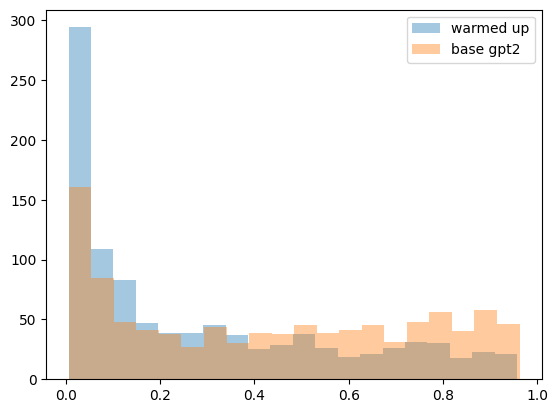

In [115]:

import matplotlib.pyplot as plt

plt.hist(warmed_up_rewards, bins=20, alpha=0.4, label='warmed up')
plt.hist(base_rewards, bins=20, alpha=0.4, label='base gpt2')
plt.legend()
plt.show()

In [ ]:

warmed_up_rewards = rewards